In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [8]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 100000.0)

(0.0, 100000.0)

In [103]:
k_space = range(-0.5, 0.5, length = 1000)
length(k_space)

1000

In [104]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)

int (generic function with 1 method)

In [105]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.0

In [106]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
        # SA[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
        # SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k, k, 0]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    """Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)"""
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
index: 1
k: -0.5
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.5, 0.0]
Spectrum: [0.592921908253833, 1.8520969480722158e-5, -0.011251259847926966, -0.06521120473940671, -8.408258806742893, -9.307947505468182]
Last point: [-0.6269292575240791, -1.2935774393588135, 4.043282747940601, -0.6269292575240791, -1.2935774393588135, 4.043282747940601]
x_sum before truncate length: 1121996
x_sum after truncate length: 560999
>>>>>>>>>>>>>>>

Initial condition: [-0.6269292575240791, -1.2935774393588135, 4.043282747940601, -0.6269292575240791, -1.2935774393588135, 4.043282747940601]
index: 2
k: -0.498998998998999
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.498998998998999, -0.498998998998999, 0.0]
Spectrum: [0.5922462962396953, 4.529716784672259e-6, -0.011161258813400684, -0.06532400468137829, -8.412936461073937, -9.310099732827792]
Last point: [-0.4666386044396258, -0.47830978727719287, 4.068088307616744, -0.4666386044

index: 14
k: -0.486986986986987
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.486986986986987, -0.486986986986987, 0.0]
Spectrum: [0.5803680704861502, 9.663771943687272e-6, -0.010468727147208068, -0.06585285775418719, -8.428241353130105, -9.29166409487698]
Last point: [-1.5780174970345888, -11.524810953918964, 3.868591620236024, -1.5780174970345888, -11.524810953918964, 3.868591620236024]
x_sum before truncate length: 1125885
x_sum after truncate length: 562944
>>>>>>>>>>>>>>>

Initial condition: [-1.5780174970345888, -11.524810953918964, 3.868591620236024, -1.5780174970345888, -11.524810953918964, 3.868591620236024]
index: 15
k: -0.48598598598598597
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48598598598598597, -0.48598598598598597, 0.0]
Spectrum: [0.5791597389640865, 1.3270734189731136e-5, -0.010434268143238903, -0.06585549831092462, -8.430442032632302, -9.290603848491305]
Last point: [-0.3812794027423722, 0.3236457674312002, 4.5840909241970325, -0.3812794027423722,

index: 27
k: -0.47397397397397395
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47397397397397395, -0.47397397397397395, 0.0]
Spectrum: [0.5654505436872759, 1.199078806940076e-5, -0.009947510012124364, -0.06600882071992592, -8.447036481830445, -9.269894151597734]
Last point: [-0.18780043913143393, 0.841509603771358, 4.292650694574485, -0.18780043913143393, 0.841509603771358, 4.292650694574485]
x_sum before truncate length: 1129044
x_sum after truncate length: 564523
>>>>>>>>>>>>>>>

Initial condition: [-0.18780043913143393, 0.841509603771358, 4.292650694574485, -0.18780043913143393, 0.841509603771358, 4.292650694574485]
index: 28
k: -0.47297297297297297
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47297297297297297, -0.47297297297297297, 0.0]
Spectrum: [0.5639456093322072, 2.8602152360730892e-5, -0.009871395662586503, -0.06600503029187026, -8.450729900128724, -9.270217159039786]
Last point: [-0.33644168687223974, 0.47654232869521124, 4.539917473087691, -0.3364416868722

index: 40
k: -0.46096096096096095
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46096096096096095, -0.46096096096096095, 0.0]
Spectrum: [0.5470428849733788, 2.463640138071051e-5, -0.009502025389291204, -0.06546425240822991, -8.472693589908102, -9.249577307219628]
Last point: [-0.3784064148412911, -0.41984345194373185, 3.669771056472006, -0.3784064148412911, -0.41984345194373185, 3.669771056472006]
x_sum before truncate length: 1131283
x_sum after truncate length: 565643
>>>>>>>>>>>>>>>

Initial condition: [-0.3784064148412911, -0.41984345194373185, 3.669771056472006, -0.3784064148412911, -0.41984345194373185, 3.669771056472006]
index: 41
k: -0.45995995995996
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45995995995996, -0.45995995995996, 0.0]
Spectrum: [0.5453016211114153, 1.248729215898126e-5, -0.009477922847390623, -0.06533725312150047, -8.475751426378887, -9.248486399473249]
Last point: [-1.5354558332204582, -10.975127531853403, 3.7042932317853703, -1.535455833220458

index: 53
k: -0.44794794794794796
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44794794794794796, -0.44794794794794796, 0.0]
Spectrum: [0.5243920208870664, 2.7032390599966743e-5, -0.009123462893924053, -0.06377295718387639, -8.50358146737893, -9.22799004610469]
Last point: [-0.7194867355213154, -1.9019087747882448, 3.962526929702265, -0.7194867355213154, -1.9019087747882448, 3.962526929702265]
x_sum before truncate length: 1133390
x_sum after truncate length: 566696
>>>>>>>>>>>>>>>

Initial condition: [-0.7194867355213154, -1.9019087747882448, 3.962526929702265, -0.7194867355213154, -1.9019087747882448, 3.962526929702265]
index: 54
k: -0.4469469469469469
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4469469469469469, -0.4469469469469469, 0.0]
Spectrum: [0.5225467788013075, -7.126236250320922e-6, -0.00910014323585328, -0.06357362442679328, -8.505591199787874, -9.225758715254932]
Last point: [-0.276391781664914, 0.6578085826734045, 4.480809566426309, -0.276391781664914, 

index: 66
k: -0.43493493493493496
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43493493493493496, -0.43493493493493496, 0.0]
Spectrum: [0.49693636307977346, 5.3997201802803155e-6, -0.008638174549465244, -0.06080110906656362, -8.539943527595868, -9.20514217862904]
Last point: [-1.3160814902448097, -6.996330427860223, 4.5280739471776865, -1.3160814902448097, -6.996330427860223, 4.5280739471776865]
x_sum before truncate length: 1134700
x_sum after truncate length: 567351
>>>>>>>>>>>>>>>

Initial condition: [-1.3160814902448097, -6.996330427860223, 4.5280739471776865, -1.3160814902448097, -6.996330427860223, 4.5280739471776865]
index: 67
k: -0.4339339339339339
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4339339339339339, -0.4339339339339339, 0.0]
Spectrum: [0.49444467284343985, 2.0148528828911516e-5, -0.008595031263630456, -0.06049382821552117, -8.543639520354319, -9.203900280179113]
Last point: [-0.7335774577063753, -2.0041564752772176, 3.9466630139909813, -0.7335774577

index: 79
k: -0.4219219219219219
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4219219219219219, -0.4219219219219219, 0.0]
Spectrum: [0.46173645937172336, 1.7877405156378104e-5, -0.007744678479855309, -0.05688816371603329, -8.58720377585987, -9.184599375611358]
Last point: [-0.33589981810030733, 0.48604860475290224, 4.584876478715559, -0.33589981810030733, 0.48604860475290224, 4.584876478715559]
x_sum before truncate length: 1135761
x_sum after truncate length: 567882
>>>>>>>>>>>>>>>

Initial condition: [-0.33589981810030733, 0.48604860475290224, 4.584876478715559, -0.33589981810030733, 0.48604860475290224, 4.584876478715559]
index: 80
k: -0.4209209209209209
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4209209209209209, -0.4209209209209209, 0.0]
Spectrum: [0.4586098489181742, 1.871550696669687e-5, -0.007619634605815303, -0.0566982138458163, -8.589715194550793, -9.18148335223139]
Last point: [-0.8501602072494848, -3.361258893224209, 3.3200948194021325, -0.85016020724948

index: 92
k: -0.4089089089089089
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4089089089089089, -0.4089089089089089, 0.0]
Spectrum: [0.407292074946436, 0.0019427009727925766, 4.150997437720658e-5, -0.0459491450611831, -8.63880752281681, -9.183282391676114]
Last point: [-0.5548871480545784, -0.3716064507212423, 4.711582867938952, -0.5548871480545784, -0.3716064507212423, 4.711582867938952]
x_sum before truncate length: 1141387
x_sum after truncate length: 570695
>>>>>>>>>>>>>>>

Initial condition: [-0.5548871480545784, -0.3716064507212423, 4.711582867938952, -0.5548871480545784, -0.3716064507212423, 4.711582867938952]
index: 93
k: -0.40790790790790793
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.40790790790790793, -0.40790790790790793, 0.0]
Spectrum: [0.388008900813724, 0.016901797877862904, -1.1520911444345366e-5, -0.042678625880967234, -8.64372222628391, -9.190219129314569]
Last point: [-1.5534736752442757, -11.244292461298237, 3.7317394313726475, -1.5534736752442757

index: 105
k: -0.3958958958958959
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3958958958958959, -0.3958958958958959, 0.0]
Spectrum: [0.42183049691950264, -2.6400519063204454e-6, -0.01584462859242161, -0.03335054586050453, -8.65388364661717, -9.242538872426127]
Last point: [-1.5345998455140744, -10.98199419149547, 3.6822652684683317, -1.5345998455140744, -10.98199419149547, 3.6822652684683317]
x_sum before truncate length: 1150266
x_sum after truncate length: 575134
>>>>>>>>>>>>>>>

Initial condition: [-1.5345998455140744, -10.98199419149547, 3.6822652684683317, -1.5345998455140744, -10.98199419149547, 3.6822652684683317]
index: 106
k: -0.3948948948948949
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3948948948948949, -0.3948948948948949, 0.0]
Spectrum: [0.42178796157606635, 2.0900793567207847e-5, -0.015618726469109771, -0.03416735556234459, -8.648413073389722, -9.240799172805707]
Last point: [-0.21468426197923063, 0.4565914580066723, 4.002136061271821, -0.214684261979

index: 118
k: -0.38288288288288286
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38288288288288286, -0.38288288288288286, 0.0]
Spectrum: [0.40079321611085517, 3.695448766864368e-5, -0.013400999110930347, -0.055105048223430486, -8.621916993391205, -9.202031638091537]
Last point: [-0.4690169041959463, -0.31484007050031215, 4.31464377456583, -0.4690169041959463, -0.31484007050031215, 4.31464377456583]
x_sum before truncate length: 1155932
x_sum after truncate length: 577967
>>>>>>>>>>>>>>>

Initial condition: [-0.4690169041959463, -0.31484007050031215, 4.31464377456583, -0.4690169041959463, -0.31484007050031215, 4.31464377456583]
index: 119
k: -0.3818818818818819
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3818818818818819, -0.3818818818818819, 0.0]
Spectrum: [0.3990698988127792, -6.796731766831695e-6, -0.013178975848604512, -0.0504598877169316, -8.618960747103696, -9.20247166030476]
Last point: [-1.0355525586553294, -4.946879833532772, 3.318768240365855, -1.035552558655

index: 131
k: -0.36986986986986986
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36986986986986986, -0.36986986986986986, 0.0]
Spectrum: [0.3818538422262468, 1.5774168739673698e-5, -0.011288617178378701, -0.037482579488008684, -8.59694672601193, -9.168115640178605]
Last point: [-0.5337488843126423, -0.2664739115951586, 4.723608156074667, -0.5337488843126423, -0.2664739115951586, 4.723608156074667]
x_sum before truncate length: 1156614
x_sum after truncate length: 578308
>>>>>>>>>>>>>>>

Initial condition: [-0.5337488843126423, -0.2664739115951586, 4.723608156074667, -0.5337488843126423, -0.2664739115951586, 4.723608156074667]
index: 132
k: -0.3688688688688689
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3688688688688689, -0.3688688688688689, 0.0]
Spectrum: [0.3807488073373512, -6.716892817054509e-6, -0.01114642253178912, -0.03710538207484284, -8.59485813593797, -9.164062511383062]
Last point: [-0.4307932546079772, -0.13597728976117893, 4.32803889551281, -0.430793254607

index: 144
k: -0.35685685685685686
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35685685685685686, -0.35685685685685686, 0.0]
Spectrum: [0.36994143973614557, 3.2481602441529067e-6, -0.009592190000991624, -0.03462712858027786, -8.57868311836586, -9.122104530002758]
Last point: [-0.27318291319117566, 0.529422677110047, 4.392229794042004, -0.27318291319117566, 0.529422677110047, 4.392229794042004]
x_sum before truncate length: 1154073
x_sum after truncate length: 577038
>>>>>>>>>>>>>>>

Initial condition: [-0.27318291319117566, 0.529422677110047, 4.392229794042004, -0.27318291319117566, 0.529422677110047, 4.392229794042004]
index: 145
k: -0.35585585585585583
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35585585585585583, -0.35585585585585583, 0.0]
Spectrum: [0.3692622444177281, 3.979503455662914e-5, -0.009456197769844748, -0.03458606446794454, -8.577047558007314, -9.118421056333293]
Last point: [-0.580246820746518, -0.4773327098067026, 4.738113626061732, -0.5802468207465

index: 157
k: -0.34384384384384387
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34384384384384387, -0.34384384384384387, 0.0]
Spectrum: [0.36032105020860306, -1.4107948895176448e-6, -0.00811576452343424, -0.0339299755662973, -8.56852939707705, -9.078789963035018]
Last point: [-0.6255831760742756, -1.1228329225573177, 4.24527354175274, -0.6255831760742756, -1.1228329225573177, 4.24527354175274]
x_sum before truncate length: 1152082
x_sum after truncate length: 576042
>>>>>>>>>>>>>>>

Initial condition: [-0.6255831760742756, -1.1228329225573177, 4.24527354175274, -0.6255831760742756, -1.1228329225573177, 4.24527354175274]
index: 158
k: -0.34284284284284283
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34284284284284283, -0.34284284284284283, 0.0]
Spectrum: [0.35964629998247766, 2.442767735548687e-5, -0.008025560107795027, -0.033888538074953595, -8.566788005656832, -9.074406074413943]
Last point: [-1.5017307615203748, -10.532134633860377, 3.6020134811917104, -1.5017307615

index: 170
k: -0.3308308308308308
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3308308308308308, -0.3308308308308308, 0.0]
Spectrum: [0.34826976359842216, 2.3711985199909037e-6, -0.006836034148418587, -0.03366462152795915, -8.574219248202951, -9.042070856153392]
Last point: [-0.7013033291222919, -1.5824451797177175, 4.208025361798322, -0.7013033291222919, -1.5824451797177175, 4.208025361798322]
x_sum before truncate length: 1146732
x_sum after truncate length: 573367
>>>>>>>>>>>>>>>

Initial condition: [-0.7013033291222919, -1.5824451797177175, 4.208025361798322, -0.7013033291222919, -1.5824451797177175, 4.208025361798322]
index: 171
k: -0.32982982982982983
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32982982982982983, -0.32982982982982983, 0.0]
Spectrum: [0.34720283433760163, 7.75620224846107e-6, -0.00673886073262178, -0.03361979395393071, -8.576201331406232, -9.040636432650802]
Last point: [-0.22157410425692073, 0.7874154595632001, 4.545459564789749, -0.22157410425

index: 183
k: -0.3178178178178178
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3178178178178178, -0.3178178178178178, 0.0]
Spectrum: [0.3302319414758432, 4.776272514989375e-5, -0.005678961900028793, -0.032738362585430905, -8.597897482848351, -9.011865216210762]
Last point: [-0.7083918478707218, -1.9211503863306658, 3.864301162566391, -0.7083918478707218, -1.9211503863306658, 3.864301162566391]
x_sum before truncate length: 1144263
x_sum after truncate length: 572133
>>>>>>>>>>>>>>>

Initial condition: [-0.7083918478707218, -1.9211503863306658, 3.864301162566391, -0.7083918478707218, -1.9211503863306658, 3.864301162566391]
index: 184
k: -0.31681681681681684
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31681681681681684, -0.31681681681681684, 0.0]
Spectrum: [0.3284711028421667, 3.72009831676083e-5, -0.005591549042969855, -0.032603896205871286, -8.601497345399345, -9.010786006385946]
Last point: [-1.5996151877486302, -11.92913231536304, 3.8302528932430926, -1.59961518774

index: 196
k: -0.3048048048048048
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3048048048048048, -0.3048048048048048, 0.0]
Spectrum: [0.30135597223230803, -8.312986442597492e-6, -0.004261793866446393, -0.030205026772008366, -8.649221981700542, -8.995242062357502]
Last point: [-0.8359029147181554, -1.9820117117540044, 4.765815486056767, -0.8359029147181554, -1.9820117117540044, 4.765815486056767]
x_sum before truncate length: 1143180
x_sum after truncate length: 571591
>>>>>>>>>>>>>>>

Initial condition: [-0.8359029147181554, -1.9820117117540044, 4.765815486056767, -0.8359029147181554, -1.9820117117540044, 4.765815486056767]
index: 197
k: -0.3038038038038038
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3038038038038038, -0.3038038038038038, 0.0]
Spectrum: [0.2982982951335095, 1.1935754344016497e-5, -0.004078301248245359, -0.030035426685324135, -8.656925116338186, -8.996900952868485]
Last point: [-1.5009456795934963, -10.533639155242321, 3.587282568901405, -1.5009456795

index: 209
k: -0.29179179179179177
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29179179179179177, -0.29179179179179177, 0.0]
Spectrum: [0.2537128717747301, 1.9148305160551224e-5, -0.0031969335484307725, -0.025659764810838388, -8.709880321392863, -9.004095861360547]
Last point: [-0.35758664922677236, -0.21532468947684258, 3.893721648755954, -0.35758664922677236, -0.21532468947684258, 3.893721648755954]
x_sum before truncate length: 1146741
x_sum after truncate length: 573372
>>>>>>>>>>>>>>>

Initial condition: [-0.35758664922677236, -0.21532468947684258, 3.893721648755954, -0.35758664922677236, -0.21532468947684258, 3.893721648755954]
index: 210
k: -0.2907907907907908
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2907907907907908, -0.2907907907907908, 0.0]
Spectrum: [0.25662251296286087, 4.411839931247221e-5, -0.014572529734921935, -0.02309236654375092, -8.706698354508408, -9.008397451167825]
Last point: [-0.8336181335144343, -2.517365249623869, 4.138028763274858, -0.8

index: 222
k: -0.27877877877877877
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27877877877877877, -0.27877877877877877, 0.0]
Spectrum: [0.25944527753986807, 1.086849772301698e-5, -0.00851145298908832, -0.016292774472669493, -8.716889507099454, -9.024483296120408]
Last point: [-1.6167944314627944, -11.85430693880048, 4.224131557354148, -1.6167944314627944, -11.85430693880048, 4.224131557354148]
x_sum before truncate length: 1148927
x_sum after truncate length: 574465
>>>>>>>>>>>>>>>

Initial condition: [-1.6167944314627944, -11.85430693880048, 4.224131557354148, -1.6167944314627944, -11.85430693880048, 4.224131557354148]
index: 223
k: -0.2777777777777778
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2777777777777778, -0.2777777777777778, 0.0]
Spectrum: [0.25843145077916274, 1.385200010836147e-5, -0.008362206701298731, -0.016431900278977646, -8.71357781521298, -9.022224924973466]
Last point: [-1.6090987808561361, -12.068344240558254, 3.8563509898028463, -1.6090987808561

index: 235
k: -0.26576576576576577
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26576576576576577, -0.26576576576576577, 0.0]
Spectrum: [0.23214959217096856, 2.883573642101203e-5, -0.006333325405043831, -0.015693801885495115, -8.665950786140634, -8.953830326115689]
Last point: [-0.7100001017234951, -1.948251890583147, 3.8455330235314684, -0.7100001017234951, -1.948251890583147, 3.8455330235314684]
x_sum before truncate length: 1138014
x_sum after truncate length: 569008
>>>>>>>>>>>>>>>

Initial condition: [-0.7100001017234951, -1.948251890583147, 3.8455330235314684, -0.7100001017234951, -1.948251890583147, 3.8455330235314684]
index: 236
k: -0.26476476476476474
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26476476476476474, -0.26476476476476474, 0.0]
Spectrum: [0.22932862611098415, 3.387703872767669e-5, -0.006077720240088012, -0.0150359375650245, -8.662254783254422, -8.945776676156022]
Last point: [-0.35621755549694445, 0.3731295915456352, 4.644264505346173, -0.3562175

index: 248
k: -0.2527527527527528
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2527527527527528, -0.2527527527527528, 0.0]
Spectrum: [0.18731802001580894, 5.880831967468785e-5, -0.0007122013374143609, -0.0013638125622624441, -8.61327792917218, -8.796751083899128]
Last point: [-1.3076125492385708, -7.921336092478393, 3.4140178183016503, -1.3076125492385708, -7.921336092478393, 3.4140178183016503]
x_sum before truncate length: 1105223
x_sum after truncate length: 552613
>>>>>>>>>>>>>>>

Initial condition: [-1.3076125492385708, -7.921336092478393, 3.4140178183016503, -1.3076125492385708, -7.921336092478393, 3.4140178183016503]
index: 249
k: -0.25175175175175174
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25175175175175174, -0.25175175175175174, 0.0]
Spectrum: [0.18355642066127256, 7.136951781682817e-5, -0.00037607341438173275, -0.0007242160999456737, -8.612051223261554, -8.782249625011582]
Last point: [-1.3688229528160358, -7.784780918834352, 4.441086228714585, -1.36882

index: 261
k: -0.23973973973973975
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23973973973973975, -0.23973973973973975, 0.0]
Spectrum: [0.13942738841234076, 0.015740831168786527, 0.008584132835923894, -8.73505650285105e-6, -8.651084250058783, -8.713262089131195]
Last point: [-0.8287443767053413, -2.261516226137254, 4.389477869711476, -0.8287443767053413, -2.261516226137254, 4.389477869711476]
x_sum before truncate length: 1081732
x_sum after truncate length: 540867
>>>>>>>>>>>>>>>

Initial condition: [-0.8287443767053413, -2.261516226137254, 4.389477869711476, -0.8287443767053413, -2.261516226137254, 4.389477869711476]
index: 262
k: -0.23873873873873874
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23873873873873874, -0.23873873873873874, 0.0]
Spectrum: [0.1399810319822797, 0.01394600748031399, 0.007867252801616773, 2.4620958644149036e-5, -8.677153876766859, -8.740127377368099]
Last point: [0.1772950033984653, -5.442669141672707, 3.729292400034508, 0.1772950033984653,

index: 274
k: -0.22672672672672672
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22672672672672672, -0.22672672672672672, 0.0]
Spectrum: [0.13048052632577536, 0.016974966480893985, 0.007637533643814126, -9.75683830057901e-6, -8.673697717852859, -8.727372455724703]
Last point: [-0.430325920336582, -0.43221441530957194, 4.002302416678837, -0.430325920336582, -0.43221441530957194, 4.002302416678837]
x_sum before truncate length: 1084926
x_sum after truncate length: 542464
>>>>>>>>>>>>>>>

Initial condition: [-0.430325920336582, -0.43221441530957194, 4.002302416678837, -0.430325920336582, -0.43221441530957194, 4.002302416678837]
index: 275
k: -0.22572572572572572
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22572572572572572, -0.22572572572572572, 0.0]
Spectrum: [0.1293043995779652, 0.017890914177324472, 0.00683552441725349, -2.8843141009313165e-5, -8.665264790293215, -8.716830119461624]
Last point: [-1.066706219650523, -4.4802008664556485, 4.166763468104606, -1.0667062196

index: 287
k: -0.21371371371371373
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21371371371371373, -0.21371371371371373, 0.0]
Spectrum: [0.12553272731377108, 0.013120743248184102, 0.0032837362230144027, -3.934731304800391e-5, -8.746132403709167, -8.79564394463145]
Last point: [-1.3251620618372137, -7.795515359756491, 3.796831948165476, -1.3251620618372137, -7.795515359756491, 3.796831948165476]
x_sum before truncate length: 1102983
x_sum after truncate length: 551493
>>>>>>>>>>>>>>>

Initial condition: [-1.3251620618372137, -7.795515359756491, 3.796831948165476, -1.3251620618372137, -7.795515359756491, 3.796831948165476]
index: 288
k: -0.21271271271271272
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21271271271271272, -0.21271271271271272, 0.0]
Spectrum: [0.12489056788553966, 0.013265864907799229, 0.0028222490979324323, -4.361036034086461e-6, -8.744115996309958, -8.792481276110577]
Last point: [-0.8742806115195113, -2.9305189918607777, 4.015105141468924, -0.8742806115

index: 300
k: -0.2007007007007007
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2007007007007007, -0.2007007007007007, 0.0]
Spectrum: [0.11735772730899706, 0.014168074350827268, 3.807213672288932e-6, -0.0011544618914445712, -8.751025723842151, -8.789386674991512]
Last point: [-1.0770980091855054, -4.500263217513073, 4.25817852730543, -1.0770980091855054, -4.500263217513073, 4.25817852730543]
x_sum before truncate length: 1096978
x_sum after truncate length: 548490
>>>>>>>>>>>>>>>

Initial condition: [-1.0770980091855054, -4.500263217513073, 4.25817852730543, -1.0770980091855054, -4.500263217513073, 4.25817852730543]
index: 301
k: -0.1996996996996997
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1996996996996997, -0.1996996996996997, 0.0]
Spectrum: [0.11671428131550596, 0.014191638438815653, 4.9252669984867934e-5, -0.00016759225943888866, -8.75311232134694, -8.792086342394091]
Last point: [-1.0547634835730186, -4.265754575632768, 4.27419840496347, -1.0547634835730186, -4

index: 313
k: -0.18768768768768768
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18768768768768768, -0.18768768768768768, 0.0]
Spectrum: [0.10909274681632354, 0.01448427664834537, 3.011862650251144e-5, -0.007142886495488194, -8.776546439831792, -8.804427430057629]
Last point: [-1.1130124349714547, -4.8958412247142915, 4.226266774481798, -1.1130124349714547, -4.8958412247142915, 4.226266774481798]
x_sum before truncate length: 1103217
x_sum after truncate length: 551610
>>>>>>>>>>>>>>>

Initial condition: [-1.1130124349714547, -4.8958412247142915, 4.226266774481798, -1.1130124349714547, -4.8958412247142915, 4.226266774481798]
index: 314
k: -0.1866866866866867
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1866866866866867, -0.1866866866866867, 0.0]
Spectrum: [0.10844486969473172, 0.014498688770438825, 4.1961420812594386e-5, -0.008276714701411565, -8.77891003285687, -8.80540263046952]
Last point: [-0.5760262504938087, -1.2833100551525407, 3.761920825301291, -0.576026250493

index: 326
k: -0.17467467467467468
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17467467467467468, -0.17467467467467468, 0.0]
Spectrum: [0.1007293613884871, 0.01483274666988706, 6.418602287347343e-5, -0.006686764442199659, -8.797808187228796, -8.821891443138755]
Last point: [-1.217073584101663, -6.270923431300026, 3.985543535392599, -1.217073584101663, -6.270923431300026, 3.985543535392599]
x_sum before truncate length: 1110684
x_sum after truncate length: 555343
>>>>>>>>>>>>>>>

Initial condition: [-1.217073584101663, -6.270923431300026, 3.985543535392599, -1.217073584101663, -6.270923431300026, 3.985543535392599]
index: 327
k: -0.17367367367367367
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17367367367367367, -0.17367367367367367, 0.0]
Spectrum: [0.10013852899721377, 0.014844850990318216, 2.710442955094483e-5, -0.006060816179183106, -8.799254254137434, -8.823580248608897]
Last point: [-0.5415301083707884, -1.0364516948431284, 3.8599651765850993, -0.5415301083707884

index: 339
k: -0.16166166166166165
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16166166166166165, -0.16166166166166165, 0.0]
Spectrum: [0.09240019905539348, 0.015206381093964877, 3.553559765189745e-5, -0.0021315980188935696, -8.813941172065313, -8.838388064909896]
Last point: [-0.9175468635826125, -3.206089953529188, 4.0911520315370495, -0.9175468635826125, -3.206089953529188, 4.0911520315370495]
x_sum before truncate length: 1115790
x_sum after truncate length: 557896
>>>>>>>>>>>>>>>

Initial condition: [-0.9175468635826125, -3.206089953529188, 4.0911520315370495, -0.9175468635826125, -3.206089953529188, 4.0911520315370495]
index: 340
k: -0.16066066066066065
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16066066066066065, -0.16066066066066065, 0.0]
Spectrum: [0.09174702280172284, 0.01523475175425975, 4.066851227112833e-5, -0.001890565852559952, -8.815659331438432, -8.840018194545733]
Last point: [-0.20158379583644095, 0.36701302428149424, 4.109776409071064, -0.201583

index: 352
k: -0.14864864864864866
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14864864864864866, -0.14864864864864866, 0.0]
Spectrum: [0.08385216139337388, 0.01560642460695937, 3.629282494872398e-5, -0.00014884333357027775, -8.829055257789436, -8.851576985421197]
Last point: [-0.84829651227907, -2.739998247223568, 4.008775704738751, -0.84829651227907, -2.739998247223568, 4.008775704738751]
x_sum before truncate length: 1121401
x_sum after truncate length: 560702
>>>>>>>>>>>>>>>

Initial condition: [-0.84829651227907, -2.739998247223568, 4.008775704738751, -0.84829651227907, -2.739998247223568, 4.008775704738751]
index: 353
k: -0.14764764764764765
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14764764764764765, -0.14764764764764765, 0.0]
Spectrum: [0.08319848106367236, 0.015616717850108005, 6.45185393518793e-5, -6.704142816485196e-5, -8.830736436265727, -8.85304029998497]
Last point: [-0.9738005895672346, -3.5417763200318593, 4.247841807919111, -0.9738005895672346, -3

index: 365
k: -0.13563563563563563
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13563563563563563, -0.13563563563563563, 0.0]
Spectrum: [0.07538558845407863, 0.016405102749964477, 4.149798265879653e-5, -0.0006939334629635438, -8.828600867960617, -8.84592929844061]
Last point: [-0.8205101897848706, -2.938388513342976, 3.5534009399058477, -0.8205101897848706, -2.938388513342976, 3.5534009399058477]
x_sum before truncate length: 1119569
x_sum after truncate length: 559786
>>>>>>>>>>>>>>>

Initial condition: [-0.8205101897848706, -2.938388513342976, 3.5534009399058477, -0.8205101897848706, -2.938388513342976, 3.5534009399058477]
index: 366
k: -0.13463463463463463
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13463463463463463, -0.13463463463463463, 0.0]
Spectrum: [0.07471309245084169, 0.01650813121207813, 1.3130801013823081e-8, -0.0007211932886881785, -8.828059646117074, -8.84490547142875]
Last point: [-0.8992880846710095, -2.889817857754891, 4.281539793658653, -0.89928808

index: 378
k: -0.12262262262262262
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12262262262262262, -0.12262262262262262, 0.0]
Spectrum: [0.0668393702213543, 0.01715464077300157, -4.812423367180052e-6, -0.0015082112864021277, -8.82579813142302, -8.838069757159301]
Last point: [-0.5623394069978199, -0.9975621037562953, 4.030225386542301, -0.5623394069978199, -0.9975621037562953, 4.030225386542301]
x_sum before truncate length: 1118029
x_sum after truncate length: 559016
>>>>>>>>>>>>>>>

Initial condition: [-0.5623394069978199, -0.9975621037562953, 4.030225386542301, -0.5623394069978199, -0.9975621037562953, 4.030225386542301]
index: 379
k: -0.12162162162162163
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12162162162162163, -0.12162162162162163, 0.0]
Spectrum: [0.06615559055522025, 0.017234750683953578, 2.302771050544996e-5, -0.0015891615210676172, -8.826125295358088, -8.838031077181366]
Last point: [-0.9120674078801068, -3.2135224476659223, 4.032985497753927, -0.9120674

index: 391
k: -0.10960960960960961
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.10960960960960961, -0.10960960960960961, 0.0]
Spectrum: [0.05811511733886817, 0.017687954020836155, 3.953821307079374e-5, -0.002491995843540626, -8.822125884463308, -8.829950887959093]
Last point: [-1.2537865131084596, -6.942117183372145, 3.7365216078549937, -1.2537865131084596, -6.942117183372145, 3.7365216078549937]
x_sum before truncate length: 1113898
x_sum after truncate length: 556950
>>>>>>>>>>>>>>>

Initial condition: [-1.2537865131084596, -6.942117183372145, 3.7365216078549937, -1.2537865131084596, -6.942117183372145, 3.7365216078549937]
index: 392
k: -0.1086086086086086
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1086086086086086, -0.1086086086086086, 0.0]
Spectrum: [0.05746097408883117, 0.017704612456497227, -1.723436830029745e-5, -0.0025628132728701984, -8.820777615220221, -8.828314326786003]
Last point: [0.09709739706753805, 0.7214032120521203, 4.115967617657063, 0.0970973970

index: 404
k: -0.0965965965965966
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.0965965965965966, -0.0965965965965966, 0.0]
Spectrum: [0.049315335807317465, 0.017679478102364924, 2.364880744658534e-5, -0.00365226473534307, -8.8143542919485, -8.818538697294697]
Last point: [-1.1950470713175656, -5.9519583290049995, 4.0539399959585465, -1.1950470713175656, -5.9519583290049995, 4.0539399959585465]
x_sum before truncate length: 1109756
x_sum after truncate length: 554879
>>>>>>>>>>>>>>>

Initial condition: [-1.1950470713175656, -5.9519583290049995, 4.0539399959585465, -1.1950470713175656, -5.9519583290049995, 4.0539399959585465]
index: 405
k: -0.09559559559559559
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09559559559559559, -0.09559559559559559, 0.0]
Spectrum: [0.048620613223601325, 0.017607095892119562, 2.8799228087096305e-5, -0.0037093794782439935, -8.815685815773872, -8.819617106833395]
Last point: [-0.8468146593690518, -2.788623695886479, 4.280271669800246, -0.846814

index: 417
k: -0.08358358358358359
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08358358358358359, -0.08358358358358359, 0.0]
Spectrum: [0.04048858534816699, 0.01656141788385033, 2.8440995029476795e-5, -0.005010204092961316, -8.808080561097093, -8.809779843284907]
Last point: [-1.229762955992614, -6.674356117058683, 3.711498508029844, -1.229762955992614, -6.674356117058683, 3.711498508029844]
x_sum before truncate length: 1107281
x_sum after truncate length: 553642
>>>>>>>>>>>>>>>

Initial condition: [-1.229762955992614, -6.674356117058683, 3.711498508029844, -1.229762955992614, -6.674356117058683, 3.711498508029844]
index: 418
k: -0.08258258258258258
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08258258258258258, -0.08258258258258258, 0.0]
Spectrum: [0.039865794976162876, 0.01634635740859812, 4.935584119105589e-5, -0.005135290822627738, -8.80612335484039, -8.807704522691298]
Last point: [-0.8684714297615995, -2.8928554334998955, 4.008080566835871, -0.8684714297615995

index: 430
k: -0.07057057057057058
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07057057057057058, -0.07057057057057058, 0.0]
Spectrum: [0.0318035398078152, 0.013134362381365878, 3.9068860360720675e-5, -0.006768342030855204, -8.79582795483511, -8.79721044821875]
Last point: [-0.9897216647996484, -3.706955081575506, 4.2211783213864305, -0.9897216647996484, -3.706955081575506, 4.2211783213864305]
x_sum before truncate length: 1103078
x_sum after truncate length: 551540
>>>>>>>>>>>>>>>

Initial condition: [-0.9897216647996484, -3.706955081575506, 4.2211783213864305, -0.9897216647996484, -3.706955081575506, 4.2211783213864305]
index: 431
k: -0.06956956956956957
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06956956956956957, -0.06956956956956957, 0.0]
Spectrum: [0.031089398109382434, 0.012735709182536156, 5.9847250918279765e-6, -0.00688304352420404, -8.79619731824918, -8.79771485810534]
Last point: [-0.41275187011524234, -0.5232015407573074, 3.8515487627847858, -0.41275187

index: 443
k: -0.05755755755755756
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05755755755755756, -0.05755755755755756, 0.0]
Spectrum: [0.022488507446637832, 0.0033657268363181513, 1.598666401269619e-5, -0.009015671625282634, -8.778562250787477, -8.786290170709215]
Last point: [-1.2143191361535437, -6.495397023785679, 3.707080249025687, -1.2143191361535437, -6.495397023785679, 3.707080249025687]
x_sum before truncate length: 1098622
x_sum after truncate length: 549312
>>>>>>>>>>>>>>>

Initial condition: [-1.2143191361535437, -6.495397023785679, 3.707080249025687, -1.2143191361535437, -6.495397023785679, 3.707080249025687]
index: 444
k: -0.05655655655655656
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05655655655655656, -0.05655655655655656, 0.0]
Spectrum: [0.02167849283867967, 0.0017863409885743437, 6.239246627050012e-5, -0.009209240285671685, -8.77507294212292, -8.784263828543809]
Last point: [-0.9606493869900066, -3.8052650159856736, 3.829851329517725, -0.960649386

index: 456
k: -0.04454454454454455
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04454454454454455, -0.04454454454454455, 0.0]
Spectrum: [0.009211654028346982, 0.009162621493497919, -4.4378390088417535e-6, -0.012284441371710622, -8.768787654844129, -8.770646058264237]
Last point: [-0.8109256522417604, -2.4812320356850126, 3.996827316854713, -0.8109256522417604, -2.4812320356850126, 3.996827316854713]
x_sum before truncate length: 1095142
x_sum after truncate length: 547572
>>>>>>>>>>>>>>>

Initial condition: [-0.8109256522417604, -2.4812320356850126, 3.996827316854713, -0.8109256522417604, -2.4812320356850126, 3.996827316854713]
index: 457
k: -0.04354354354354354
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04354354354354354, -0.04354354354354354, 0.0]
Spectrum: [0.009707623418797674, 0.00962511559403506, 2.4398438089047202e-5, -0.012595091528202746, -8.77087248944908, -8.771083471206392]
Last point: [-1.0550158291286786, -4.361966836315276, 4.171017159941868, -1.05501

>>>>>>>>>>>>>>>

Initial condition: [-0.9511138936661399, -3.901421086451855, 3.8402813542740097, -0.9511138936661399, -3.901421086451855, 3.8402813542740097]
index: 469
k: -0.03153153153153153
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03153153153153153, -0.03153153153153153, 0.0]
Spectrum: [0.011155282431144114, 0.011138538095557097, 6.708700575942982e-6, -0.0178375200698638, -8.753996001379559, -8.771425562892155]
Last point: [-1.1336548653417855, -5.231439964389038, 4.097678763182164, -1.1336548653417855, -5.231439964389038, 4.097678763182164]
x_sum before truncate length: 1089581
x_sum after truncate length: 544792
>>>>>>>>>>>>>>>

Initial condition: [-1.1336548653417855, -5.231439964389038, 4.097678763182164, -1.1336548653417855, -5.231439964389038, 4.097678763182164]
index: 470
k: -0.03053053053053053
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03053053053053053, -0.03053053053053053, 0.0]
Spectrum: [0.011058365944565551, 0.011049308620766913, 2.282585504909

x_sum before truncate length: 1083178
x_sum after truncate length: 541590
>>>>>>>>>>>>>>>

Initial condition: [0.9032473758069277, 0.006615801999238554, 3.7226701142243512, 0.9032473758069277, 0.006615801999238554, 3.7226701142243512]
index: 482
k: -0.018518518518518517
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.018518518518518517, -0.018518518518518517, 0.0]
Spectrum: [0.00872312436883551, 0.008667464060084394, 2.7128714244416305e-5, -0.034022297473214294, -8.72528789929877, -8.76359532090766]
Last point: [-0.5940081919801171, -1.5041753932633581, 3.6182696016681297, -0.5940081919801171, -1.5041753932633581, 3.6182696016681297]
x_sum before truncate length: 1082407
x_sum after truncate length: 541205
>>>>>>>>>>>>>>>

Initial condition: [-0.5940081919801171, -1.5041753932633581, 3.6182696016681297, -0.5940081919801171, -1.5041753932633581, 3.6182696016681297]
index: 483
k: -0.017517517517517518
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.017517517517517518, -0.0175

Last point: [-0.8896253265478384, -3.06334252370349, 4.00098541302897, -0.8896253265478384, -3.06334252370349, 4.00098541302897]
x_sum before truncate length: 1072511
x_sum after truncate length: 536257
>>>>>>>>>>>>>>>

Initial condition: [-0.8896253265478384, -3.06334252370349, 4.00098541302897, -0.8896253265478384, -3.06334252370349, 4.00098541302897]
index: 495
k: -0.0055055055055055055
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.0055055055055055055, -0.0055055055055055055, 0.0]
Spectrum: [0.0019393227180211725, 0.0019461864396484244, -1.1948544859899354e-6, -0.021017584000820582, -8.723814432998774, -8.744877625606074]
Last point: [-0.9430834844780187, -3.4550400149372864, 4.050187611435147, -0.9430834844780187, -3.4550400149372864, 4.050187611435147]
x_sum before truncate length: 1072242
x_sum after truncate length: 536122
>>>>>>>>>>>>>>>

Initial condition: [-0.9430834844780187, -3.4550400149372864, 4.050187611435147, -0.9430834844780187, -3.4550400149372864, 4.05018761

Spectrum: [0.005325900455937209, 5.400317432908857e-5, -0.008284889233852786, -0.009573034259317395, -8.71658930313395, -8.72764899133929]
Last point: [-0.9647357753263347, -3.4921740272180855, 4.2154308166235985, -0.9647357753263347, -3.4921740272180855, 4.2154308166235985]
x_sum before truncate length: 1066483
x_sum after truncate length: 533243
>>>>>>>>>>>>>>>

Initial condition: [-0.9647357753263347, -3.4921740272180855, 4.2154308166235985, -0.9647357753263347, -3.4921740272180855, 4.2154308166235985]
index: 508
k: 0.0075075075075075074
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0075075075075075074, 0.0075075075075075074, 0.0]
Spectrum: [0.005612574176136687, 5.556369522518787e-5, -0.006919603615101204, -0.008758540240018842, -8.716882542705127, -8.729489498532887]
Last point: [-0.9467565060482938, -3.47686087456161, 4.060563288207944, -0.9467565060482938, -3.47686087456161, 4.060563288207944]
x_sum before truncate length: 1065876
x_sum after truncate length: 532939
>>>>>

index: 520
k: 0.01951951951951952
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01951951951951952, 0.01951951951951952, 0.0]
Spectrum: [0.009669070929266117, 0.007383510607614851, -2.57429889359022e-5, -0.008972579866230965, -8.635835367443848, -8.641913569430054]
Last point: [-0.7166522662697461, -1.8728136484230158, 3.987027667615068, -0.7166522662697461, -1.8728136484230158, 3.987027667615068]
x_sum before truncate length: 1037673
x_sum after truncate length: 518838
>>>>>>>>>>>>>>>

Initial condition: [-0.7166522662697461, -1.8728136484230158, 3.987027667615068, -0.7166522662697461, -1.8728136484230158, 3.987027667615068]
index: 521
k: 0.02052052052052052
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02052052052052052, 0.02052052052052052, 0.0]
Spectrum: [0.009693146773007035, 0.008077305530140029, -7.815829005751683e-5, -0.009527366680572257, -8.629889555946612, -8.635401941558362]
Last point: [-0.7013076732182079, -2.0570430931790713, 3.6654534588417484, -0.701307673

index: 533
k: 0.032532532532532535
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.032532532532532535, 0.032532532532532535, 0.0]
Spectrum: [0.01071070914317485, 0.009349288529383349, -1.6019382649733887e-5, -0.012402782889139872, -8.60204919226146, -8.609007939325737]
Last point: [-1.15335146567357, -5.763726318406976, 3.749621410989976, -1.15335146567357, -5.763726318406976, 3.749621410989976]
x_sum before truncate length: 1031492
x_sum after truncate length: 515747
>>>>>>>>>>>>>>>

Initial condition: [-1.15335146567357, -5.763726318406976, 3.749621410989976, -1.15335146567357, -5.763726318406976, 3.749621410989976]
index: 534
k: 0.033533533533533534
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.033533533533533534, 0.033533533533533534, 0.0]
Spectrum: [0.010166304604316606, 0.008003540158269002, -1.1161559564166396e-5, -0.0061963458407474645, -8.602949314337568, -8.616007617663499]
Last point: [-0.9792230506216971, -3.806781837013848, 4.006558248212139, -0.979223050621697

index: 546
k: 0.045545545545545546
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.045545545545545546, 0.045545545545545546, 0.0]
Spectrum: [0.014492545402814406, 0.01105066754073293, 0.008050749919636927, 4.59499953557213e-5, -8.587643654551266, -8.627651025797153]
Last point: [-0.8058896925651803, -2.468842240052984, 3.9716494240227136, -0.8058896925651803, -2.468842240052984, 3.9716494240227136]
x_sum before truncate length: 1028202
x_sum after truncate length: 514102
>>>>>>>>>>>>>>>

Initial condition: [-0.8058896925651803, -2.468842240052984, 3.9716494240227136, -0.8058896925651803, -2.468842240052984, 3.9716494240227136]
index: 547
k: 0.046546546546546545
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.046546546546546545, 0.046546546546546545, 0.0]
Spectrum: [0.014433672832967703, 0.011227846270986483, 0.008713189079167344, -5.693447314171969e-6, -8.590367191593653, -8.63164163313248]
Last point: [-1.0279031723596144, -4.28715984898661, 3.967208787257206, -1.02790317235

index: 559
k: 0.05855855855855856
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05855855855855856, 0.05855855855855856, 0.0]
Spectrum: [0.017455228204044937, 0.013934633571335547, 0.01096764257820598, 4.995342550470257e-6, -8.578670699114513, -8.635370584361313]
Last point: [-0.9299905241470446, -3.2692967064385434, 4.188058777356265, -0.9299905241470446, -3.2692967064385434, 4.188058777356265]
x_sum before truncate length: 1023207
x_sum after truncate length: 511605
>>>>>>>>>>>>>>>

Initial condition: [-0.9299905241470446, -3.2692967064385434, 4.188058777356265, -0.9299905241470446, -3.2692967064385434, 4.188058777356265]
index: 560
k: 0.059559559559559556
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.059559559559559556, 0.059559559559559556, 0.0]
Spectrum: [0.018138682433530246, 0.014137338405903588, 0.012295405774048744, 6.934479941531436e-6, -8.573521783626381, -8.630310508742275]
Last point: [-0.8951628428355172, -3.2193270511807817, 3.874989955187568, -0.89516284283

index: 572
k: 0.07157157157157157
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07157157157157157, 0.07157157157157157, 0.0]
Spectrum: [0.019650719762686345, 0.016430698114081557, 0.009872519387147529, -5.934915325833483e-6, -8.58399614355314, -8.654331380579595]
Last point: [-0.8978117440734634, -3.165453642489581, 3.9592588362255734, -0.8978117440734634, -3.165453642489581, 3.9592588362255734]
x_sum before truncate length: 1027895
x_sum after truncate length: 513949
>>>>>>>>>>>>>>>

Initial condition: [-0.8978117440734634, -3.165453642489581, 3.9592588362255734, -0.8978117440734634, -3.165453642489581, 3.9592588362255734]
index: 573
k: 0.07257257257257257
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07257257257257257, 0.07257257257257257, 0.0]
Spectrum: [0.020308938320464452, 0.016665653995567006, 0.011353131233898209, -1.2153962040981355e-5, -8.57635660042021, -8.646540655417853]
Last point: [-0.613546993310707, -1.3193770587420124, 3.9617950086498874, -0.613546993310

index: 585
k: 0.08458458458458458
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08458458458458458, 0.08458458458458458, 0.0]
Spectrum: [0.02163248200313758, 0.01951583069956084, 0.012190134036628664, -1.0663128646107472e-5, -8.5626843589908, -8.64287947768946]
Last point: [-0.3338784014075777, -0.38858812411196925, 3.7563488937789566, -0.3338784014075777, -0.38858812411196925, 3.7563488937789566]
x_sum before truncate length: 1022228
x_sum after truncate length: 511115
>>>>>>>>>>>>>>>

Initial condition: [-0.3338784014075777, -0.38858812411196925, 3.7563488937789566, -0.3338784014075777, -0.38858812411196925, 3.7563488937789566]
index: 586
k: 0.08558558558558559
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08558558558558559, 0.08558558558558559, 0.0]
Spectrum: [0.021596473148976218, 0.019854039783033517, 0.012029011350268988, -4.4892683217132686e-5, -8.56206413642627, -8.643316697953342]
Last point: [-0.9514735007619328, -3.566564768575857, 4.005446523719297, -0.95147350

index: 598
k: 0.09759759759759759
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09759759759759759, 0.09759759759759759, 0.0]
Spectrum: [0.022662555445815004, 0.021684177771808377, 0.012203410428430733, 1.9348738081925346e-5, -8.555618311265814, -8.646188458008801]
Last point: [-1.070217447481383, -4.6631562175375265, 4.003986350896458, -1.070217447481383, -4.6631562175375265, 4.003986350896458]
x_sum before truncate length: 1018335
x_sum after truncate length: 509169
>>>>>>>>>>>>>>>

Initial condition: [-1.070217447481383, -4.6631562175375265, 4.003986350896458, -1.070217447481383, -4.6631562175375265, 4.003986350896458]
index: 599
k: 0.0985985985985986
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0985985985985986, 0.0985985985985986, 0.0]
Spectrum: [0.02284630970928368, 0.02151191001624684, 0.012000709901851982, -1.2973957790487791e-5, -8.557617949259598, -8.649041430364107]
Last point: [-1.0001248571179169, -4.095518927035336, 3.8945304787453376, -1.0001248571179169, -

index: 611
k: 0.11061061061061062
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11061061061061062, 0.11061061061061062, 0.0]
Spectrum: [0.023575400347927777, 0.022565878973118483, 0.011352993007111449, 4.442030524736625e-6, -8.558441463729391, -8.659023245272666]
Last point: [-0.7060456874357308, -1.8169368316440215, 3.979953638716868, -0.7060456874357308, -1.8169368316440215, 3.979953638716868]
x_sum before truncate length: 1022123
x_sum after truncate length: 511063
>>>>>>>>>>>>>>>

Initial condition: [-0.7060456874357308, -1.8169368316440215, 3.979953638716868, -0.7060456874357308, -1.8169368316440215, 3.979953638716868]
index: 612
k: 0.11161161161161161
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11161161161161161, 0.11161161161161161, 0.0]
Spectrum: [0.023666587829665266, 0.022531076622673382, 0.011373103641245386, -8.354948487866561e-6, -8.559490556652943, -8.660721829512568]
Last point: [-0.9970492111713726, -3.9042091954690417, 4.075747727860646, -0.997049211171

index: 624
k: 0.12362362362362363
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12362362362362363, 0.12362362362362363, 0.0]
Spectrum: [0.024607201664957317, 0.023411359211489617, 0.011211113938657372, -6.0557019555624365e-6, -8.554058084903422, -8.663726332169182]
Last point: [-0.9468266618555217, -3.6459383020337266, 3.872783151215227, -0.9468266618555217, -3.6459383020337266, 3.872783151215227]
x_sum before truncate length: 1022612
x_sum after truncate length: 511307
>>>>>>>>>>>>>>>

Initial condition: [-0.9468266618555217, -3.6459383020337266, 3.872783151215227, -0.9468266618555217, -3.6459383020337266, 3.872783151215227]
index: 625
k: 0.12462462462462462
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12462462462462462, 0.12462462462462462, 0.0]
Spectrum: [0.02443748609051413, 0.023371316743431396, 0.010787765479179106, -2.055752786698965e-5, -8.558671932118889, -8.669206871988148]
Last point: [-0.8343930122799653, -2.721615842890333, 3.9157773848899664, -0.83439301227

index: 637
k: 0.13663663663663664
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13663663663663664, 0.13663663663663664, 0.0]
Spectrum: [0.023800742749570784, 0.023751859297118455, 7.151671864556802e-5, -0.004660047326685102, -8.567359484285465, -8.700358851395979]
Last point: [-1.1370489619772428, -5.465347110104599, 3.8820000428410295, -1.1370489619772428, -5.465347110104599, 3.8820000428410295]
x_sum before truncate length: 1034729
x_sum after truncate length: 517366
>>>>>>>>>>>>>>>

Initial condition: [-1.1370489619772428, -5.465347110104599, 3.8820000428410295, -1.1370489619772428, -5.465347110104599, 3.8820000428410295]
index: 638
k: 0.13763763763763764
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13763763763763764, 0.13763763763763764, 0.0]
Spectrum: [0.023834821423183022, 0.023796065251074555, 2.940727229092619e-5, -0.0015986835619744239, -8.570664380958847, -8.701236030954808]
Last point: [-1.182525867595197, -5.942096287829023, 3.9095628184194675, -1.18252586759

index: 650
k: 0.14964964964964966
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14964964964964966, 0.14964964964964966, 0.0]
Spectrum: [0.025944208276181244, 0.024581164922579106, 0.011023812598585585, -1.398351675550243e-5, -8.55098926071524, -8.677093527838291]
Last point: [-0.8853253600910848, -3.1369838784755646, 3.8808698362790035, -0.8853253600910848, -3.1369838784755646, 3.8808698362790035]
x_sum before truncate length: 1027612
x_sum after truncate length: 513807
>>>>>>>>>>>>>>>

Initial condition: [-0.8853253600910848, -3.1369838784755646, 3.8808698362790035, -0.8853253600910848, -3.1369838784755646, 3.8808698362790035]
index: 651
k: 0.15065065065065064
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15065065065065064, 0.15065065065065064, 0.0]
Spectrum: [0.026045235462558342, 0.02446474129350347, 0.010937046444426722, -1.938718948153157e-5, -8.551829922653214, -8.678639858513582]
Last point: [-1.0589215742787284, -4.605947361414806, 3.944438275834153, -1.0589215742

index: 663
k: 0.16266266266266266
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16266266266266266, 0.16266266266266266, 0.0]
Spectrum: [0.026274315489014547, 0.024942982953426306, 0.010571154560479974, -1.8989002225877273e-5, -8.551499026533921, -8.685682693608296]
Last point: [-0.8673149305434855, -2.99371667943314, 3.885632723884049, -0.8673149305434855, -2.99371667943314, 3.885632723884049]
x_sum before truncate length: 1030509
x_sum after truncate length: 515256
>>>>>>>>>>>>>>>

Initial condition: [-0.8673149305434855, -2.99371667943314, 3.885632723884049, -0.8673149305434855, -2.99371667943314, 3.885632723884049]
index: 664
k: 0.16366366366366367
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16366366366366367, 0.16366366366366367, 0.0]
Spectrum: [0.02620733932132657, 0.024851270587807898, 0.009500320588272007, -9.846309732831338e-6, -8.55429451010754, -8.690041131126906]
Last point: [-0.9654976515733197, -3.61209139224056, 4.089542451086416, -0.9654976515733197, -3.6

index: 676
k: 0.17567567567567569
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17567567567567569, 0.17567567567567569, 0.0]
Spectrum: [0.027068048488519583, 0.025407573667054588, 0.010487653241247334, 2.067971925739957e-5, -8.542734863149237, -8.684568337130049]
Last point: [-0.9466817589853715, -3.7520913753332064, 3.753085656579771, -0.9466817589853715, -3.7520913753332064, 3.753085656579771]
x_sum before truncate length: 1026935
x_sum after truncate length: 513469
>>>>>>>>>>>>>>>

Initial condition: [-0.9466817589853715, -3.7520913753332064, 3.753085656579771, -0.9466817589853715, -3.7520913753332064, 3.753085656579771]
index: 677
k: 0.17667667667667666
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17667667667667666, 0.17667667667667666, 0.0]
Spectrum: [0.02718918704373369, 0.025625955786155147, 0.011276098506023742, -1.0640629945382462e-5, -8.537218021353201, -8.67900992539565]
Last point: [-1.1727044454402096, -5.893212726416774, 3.8423759491236935, -1.1727044454402

index: 689
k: 0.18868868868868868
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18868868868868868, 0.18868868868868868, 0.0]
Spectrum: [0.027366497119932245, 0.025985625162647786, 0.009916028552454647, -4.554638562540261e-5, -8.5355562265176, -8.685357468188492]
Last point: [-0.9215901839072002, -3.3706548711962716, 3.9450229586804433, -0.9215901839072002, -3.3706548711962716, 3.9450229586804433]
x_sum before truncate length: 1024451
x_sum after truncate length: 512227
>>>>>>>>>>>>>>>

Initial condition: [-0.9215901839072002, -3.3706548711962716, 3.9450229586804433, -0.9215901839072002, -3.3706548711962716, 3.9450229586804433]
index: 690
k: 0.1896896896896897
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1896896896896897, 0.1896896896896897, 0.0]
Spectrum: [0.027680933161384345, 0.025929554797475236, 0.010861698201041381, -2.4706190649202094e-5, -8.532877097632785, -8.682318806440874]
Last point: [-1.0689594206952122, -4.6647557309488805, 3.988583484084945, -1.06895942069

index: 702
k: 0.2017017017017017
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2017017017017017, 0.2017017017017017, 0.0]
Spectrum: [0.02837871811304774, 0.026113651714709366, 0.011197554522023173, -4.554689893873282e-5, -8.5254448810392, -8.681038781332436]
Last point: [-0.9832822500526187, -3.8192528339376395, 4.033074812807235, -0.9832822500526187, -3.8192528339376395, 4.033074812807235]
x_sum before truncate length: 1022755
x_sum after truncate length: 511379
>>>>>>>>>>>>>>>

Initial condition: [-0.9832822500526187, -3.8192528339376395, 4.033074812807235, -0.9832822500526187, -3.8192528339376395, 4.033074812807235]
index: 703
k: 0.20270270270270271
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.20270270270270271, 0.20270270270270271, 0.0]
Spectrum: [0.028282872865202417, 0.026280181402433298, 0.01092244564854867, 1.0990025409396693e-5, -8.524055403772644, -8.680421500284154]
Last point: [-0.9834848419856628, -3.7972870244532273, 4.059490706923452, -0.9834848419856628, 

index: 715
k: 0.2147147147147147
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2147147147147147, 0.2147147147147147, 0.0]
Spectrum: [0.028279003918638038, 0.0267384221995127, 0.010154106786452361, -2.347554396018698e-5, -8.520416290311228, -8.683796038305895]
Last point: [-0.14336711320015436, 0.015563408497710044, 3.8561987493618934, -0.14336711320015436, 0.015563408497710044, 3.8561987493618934]
x_sum before truncate length: 1021129
x_sum after truncate length: 510566
>>>>>>>>>>>>>>>

Initial condition: [-0.14336711320015436, 0.015563408497710044, 3.8561987493618934, -0.14336711320015436, 0.015563408497710044, 3.8561987493618934]
index: 716
k: 0.2157157157157157
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2157157157157157, 0.2157157157157157, 0.0]
Spectrum: [0.028236539361437434, 0.026663386380179656, 0.009854215499841999, -4.277679047127748e-6, -8.522237616851433, -8.686427107690648]
Last point: [-0.6207191090122346, -1.3601083557843838, 3.9652294210857595, -0.620719

index: 728
k: 0.22772772772772773
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22772772772772773, 0.22772772772772773, 0.0]
Spectrum: [0.027316853492582314, 0.027234709303582984, 0.0027976683933284867, -9.063444784550412e-5, -8.524564296528462, -8.701994583674319]
Last point: [-0.9657083400070997, -3.5742843672845406, 4.133851300881864, -0.9657083400070997, -3.5742843672845406, 4.133851300881864]
x_sum before truncate length: 1027690
x_sum after truncate length: 513846
>>>>>>>>>>>>>>>

Initial condition: [-0.9657083400070997, -3.5742843672845406, 4.133851300881864, -0.9657083400070997, -3.5742843672845406, 4.133851300881864]
index: 729
k: 0.22872872872872874
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22872872872872874, 0.22872872872872874, 0.0]
Spectrum: [0.02725168998764227, 0.027211186227807528, 0.002685373876261556, 9.427525621569134e-6, -8.527252069685236, -8.705126829796585]
Last point: [-0.6581520688207526, -1.5890180080377465, 3.9296577586237937, -0.65815206882

index: 741
k: 0.24074074074074073
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24074074074074073, 0.24074074074074073, 0.0]
Spectrum: [0.027408032023274253, 0.027361002961334865, 1.2892335240645074e-6, -0.00217556990516355, -8.519545810991149, -8.70827615445061]
Last point: [-0.6173130142354346, -1.330312804140648, 3.9814686719749472, -0.6173130142354346, -1.330312804140648, 3.9814686719749472]
x_sum before truncate length: 1028426
x_sum after truncate length: 514214
>>>>>>>>>>>>>>>

Initial condition: [-0.6173130142354346, -1.330312804140648, 3.9814686719749472, -0.6173130142354346, -1.330312804140648, 3.9814686719749472]
index: 742
k: 0.24174174174174173
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24174174174174173, 0.24174174174174173, 0.0]
Spectrum: [0.027428619295702943, 0.02738484864512975, 5.17375293541381e-5, -0.003394571079210883, -8.518030157622944, -8.708410126368559]
Last point: [-0.7386543064510637, -2.096282449267553, 3.8904921447966614, -0.73865430645106

index: 754
k: 0.25375375375375375
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25375375375375375, 0.25375375375375375, 0.0]
Spectrum: [0.02970262395316125, 0.026809527265225796, 0.011088585947840675, 7.504201793004751e-6, -8.505342732248268, -8.687139457756087]
Last point: [-1.0008524838196042, -3.8875044354089, 4.132779967918256, -1.0008524838196042, -3.8875044354089, 4.132779967918256]
x_sum before truncate length: 1019656
x_sum after truncate length: 509829
>>>>>>>>>>>>>>>

Initial condition: [-1.0008524838196042, -3.8875044354089, 4.132779967918256, -1.0008524838196042, -3.8875044354089, 4.132779967918256]
index: 755
k: 0.25475475475475473
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25475475475475473, 0.25475475475475473, 0.0]
Spectrum: [0.029629467213323043, 0.02674597053327357, 0.011205546323024876, 5.4365756555651735e-6, -8.507882995496162, -8.689982640809143]
Last point: [-1.1377193664553742, -5.458228793821121, 3.8977011370343098, -1.1377193664553742, -5.45822

index: 767
k: 0.26676676676676675
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26676676676676675, 0.26676676676676675, 0.0]
Spectrum: [0.03049983752352156, 0.026558473346410833, 0.011649000782903375, -5.954052910503202e-6, -8.498163093801843, -8.685529190355036]
Last point: [-1.0000677659723343, -4.0792050263937725, 3.912315406010708, -1.0000677659723343, -4.0792050263937725, 3.912315406010708]
x_sum before truncate length: 1018831
x_sum after truncate length: 509417
>>>>>>>>>>>>>>>

Initial condition: [-1.0000677659723343, -4.0792050263937725, 3.912315406010708, -1.0000677659723343, -4.0792050263937725, 3.912315406010708]
index: 768
k: 0.2677677677677678
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2677677677677678, 0.2677677677677678, 0.0]
Spectrum: [0.03068953808282196, 0.026082106450970602, 0.0115820140725348, -5.416822639962115e-6, -8.502497064107276, -8.690368241233186]
Last point: [-0.981979154502683, -3.7631726102193657, 4.082668159329154, -0.981979154502683, -3

index: 780
k: 0.2797797797797798
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2797797797797798, 0.2797797797797798, 0.0]
Spectrum: [0.030885569792711284, 0.025711838904111408, 0.010881243275286064, -7.373247682355429e-7, -8.504666716892586, -8.69879183868174]
Last point: [-0.9764215761779461, -3.7470008739931977, 4.046020338246571, -0.9764215761779461, -3.7470008739931977, 4.046020338246571]
x_sum before truncate length: 1022435
x_sum after truncate length: 511219
>>>>>>>>>>>>>>>

Initial condition: [-0.9764215761779461, -3.7470008739931977, 4.046020338246571, -0.9764215761779461, -3.7470008739931977, 4.046020338246571]
index: 781
k: 0.2807807807807808
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2807807807807808, 0.2807807807807808, 0.0]
Spectrum: [0.030710103140138795, 0.025791156514300497, 0.010891906196932066, 3.971599035051344e-7, -8.50672761077271, -8.70123322702262]
Last point: [-0.9720233877145594, -3.7922361373881777, 3.952666349254414, -0.9720233877145594, -3.

index: 793
k: 0.2927927927927928
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2927927927927928, 0.2927927927927928, 0.0]
Spectrum: [0.03075574102966155, 0.02590769720209382, 0.010770055821699799, -3.261549692277075e-5, -8.503164220339297, -8.703290924813569]
Last point: [-0.8760969322894847, -3.036313758650821, 3.9142802506521743, -0.8760969322894847, -3.036313758650821, 3.9142802506521743]
x_sum before truncate length: 1023046
x_sum after truncate length: 511524
>>>>>>>>>>>>>>>

Initial condition: [-0.8760969322894847, -3.036313758650821, 3.9142802506521743, -0.8760969322894847, -3.036313758650821, 3.9142802506521743]
index: 794
k: 0.2937937937937938
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2937937937937938, 0.2937937937937938, 0.0]
Spectrum: [0.03079333780077016, 0.025902605419858615, 0.011169368551531916, -1.232090132784914e-6, -8.502839920943458, -8.702990758930818]
Last point: [-1.0219307313254766, -4.157630502147802, 4.048774640507045, -1.0219307313254766, -4.

index: 806
k: 0.3058058058058058
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3058058058058058, 0.3058058058058058, 0.0]
Spectrum: [0.03089709047251091, 0.026090893022101505, 0.011326257632467352, -4.351898689273706e-5, -8.497883698119372, -8.703266412664696]
Last point: [-0.9474772866183616, -3.702698155486523, 3.816106434339599, -0.9474772866183616, -3.702698155486523, 3.816106434339599]
x_sum before truncate length: 1021534
x_sum after truncate length: 510768
>>>>>>>>>>>>>>>

Initial condition: [-0.9474772866183616, -3.702698155486523, 3.816106434339599, -0.9474772866183616, -3.702698155486523, 3.816106434339599]
index: 807
k: 0.30680680680680683
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.30680680680680683, 0.30680680680680683, 0.0]
Spectrum: [0.031091556741438337, 0.02586905208988384, 0.010403521273034679, -3.255964663736025e-5, -8.497075320907594, -8.703772136043948]
Last point: [-0.8587050496572687, -2.8679378678083496, 3.954979484172223, -0.8587050496572687, -2

index: 819
k: 0.3188188188188188
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3188188188188188, 0.3188188188188188, 0.0]
Spectrum: [0.030762312431171456, 0.026646846477880938, 0.010853400214374526, 1.2685421420953995e-5, -8.489140004954447, -8.700590428523027]
Last point: [-1.0211286996716322, -4.415672826023139, 3.7551851854186835, -1.0211286996716322, -4.415672826023139, 3.7551851854186835]
x_sum before truncate length: 1018495
x_sum after truncate length: 509249
>>>>>>>>>>>>>>>

Initial condition: [-1.0211286996716322, -4.415672826023139, 3.7551851854186835, -1.0211286996716322, -4.415672826023139, 3.7551851854186835]
index: 820
k: 0.31981981981981983
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31981981981981983, 0.31981981981981983, 0.0]
Spectrum: [0.030765533409234484, 0.026862001378972884, 0.010969791245841626, -5.5413859631482935e-6, -8.485185694289154, -8.696976870190179]
Last point: [-0.9725616287336768, -3.7728213024524146, 3.9796090967500604, -0.972561628733

Excessive output truncated after 524313 bytes.

In [72]:
using CairoMakie

In [83]:
CairoMakie.activate!()

In [95]:
using JLD

In [123]:
save("spectrum_k1_k2_L2.jld", "data", spectrum_array)

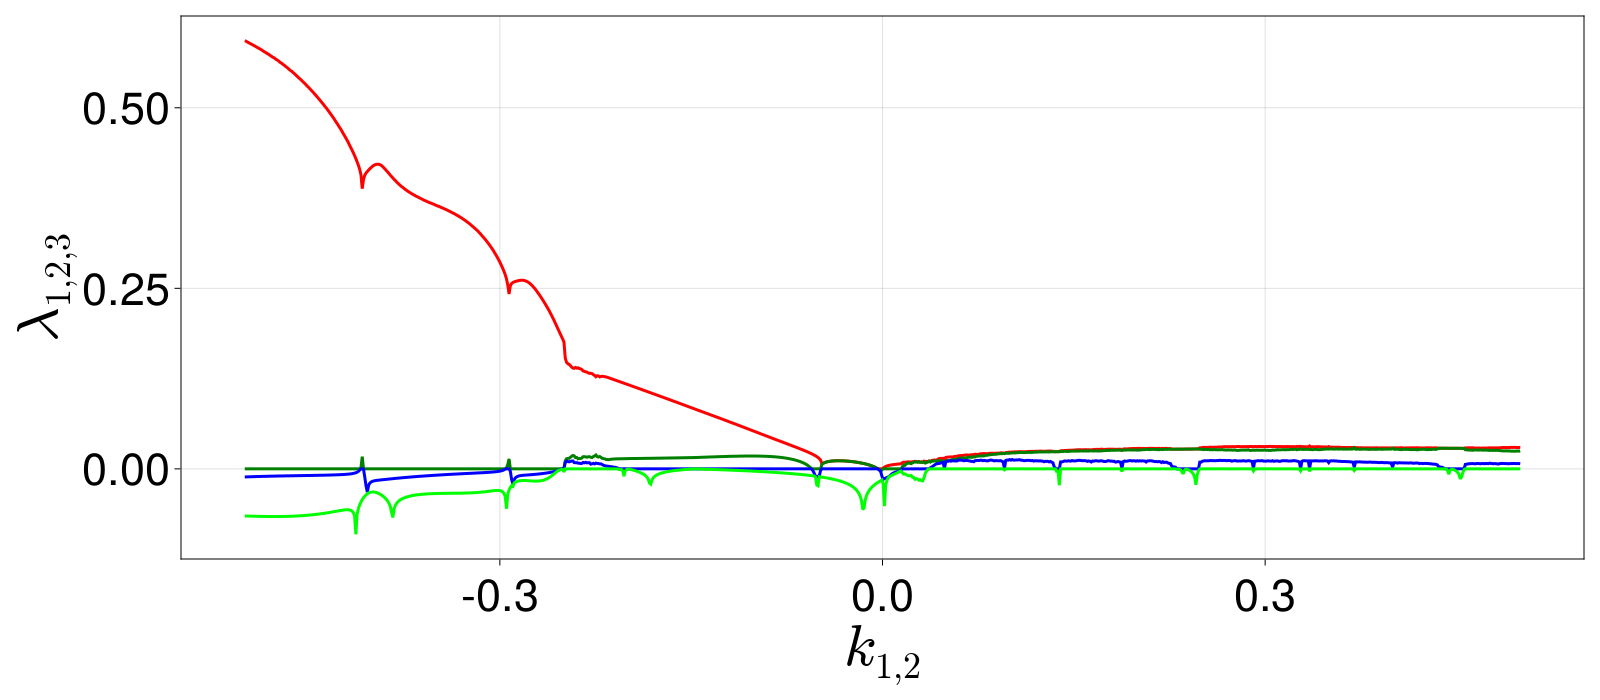

In [149]:
# L2

f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45  )

lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.0, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.0, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.0, color = "blue")
lines!(ax, k_space, spectrum_array[4, :], linewidth = 3.0, color = "lime")

# save("LE_orbit_full.eps", f)
f

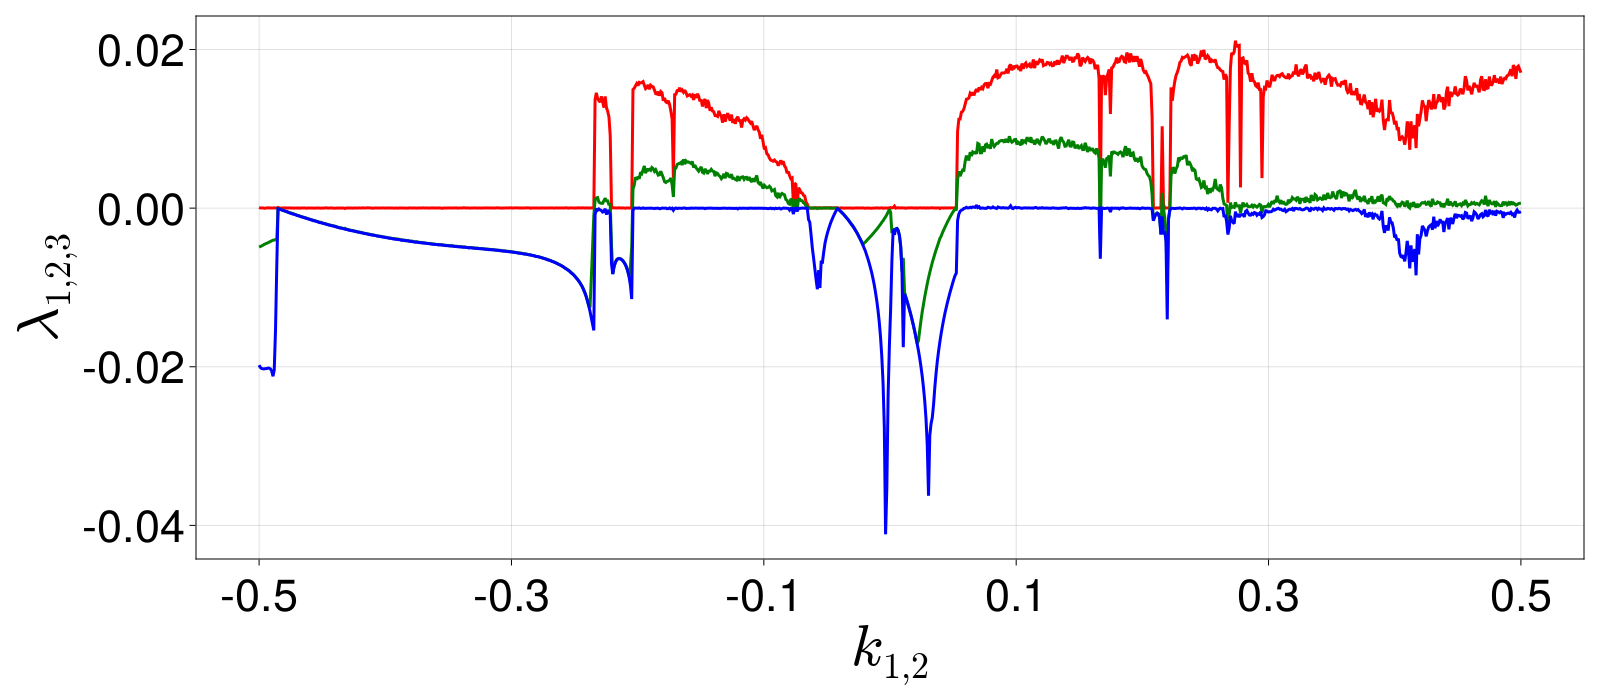

In [102]:
# L1
ticks = range(-0.5, 0.5, length = 6)
yticks = range(-0.04, 0.02, length = 4)
f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45, xticks = ticks, yticks = yticks  )


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.0, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.0, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.0, color = "blue")
save("LE_orbit_full.eps", f)
f

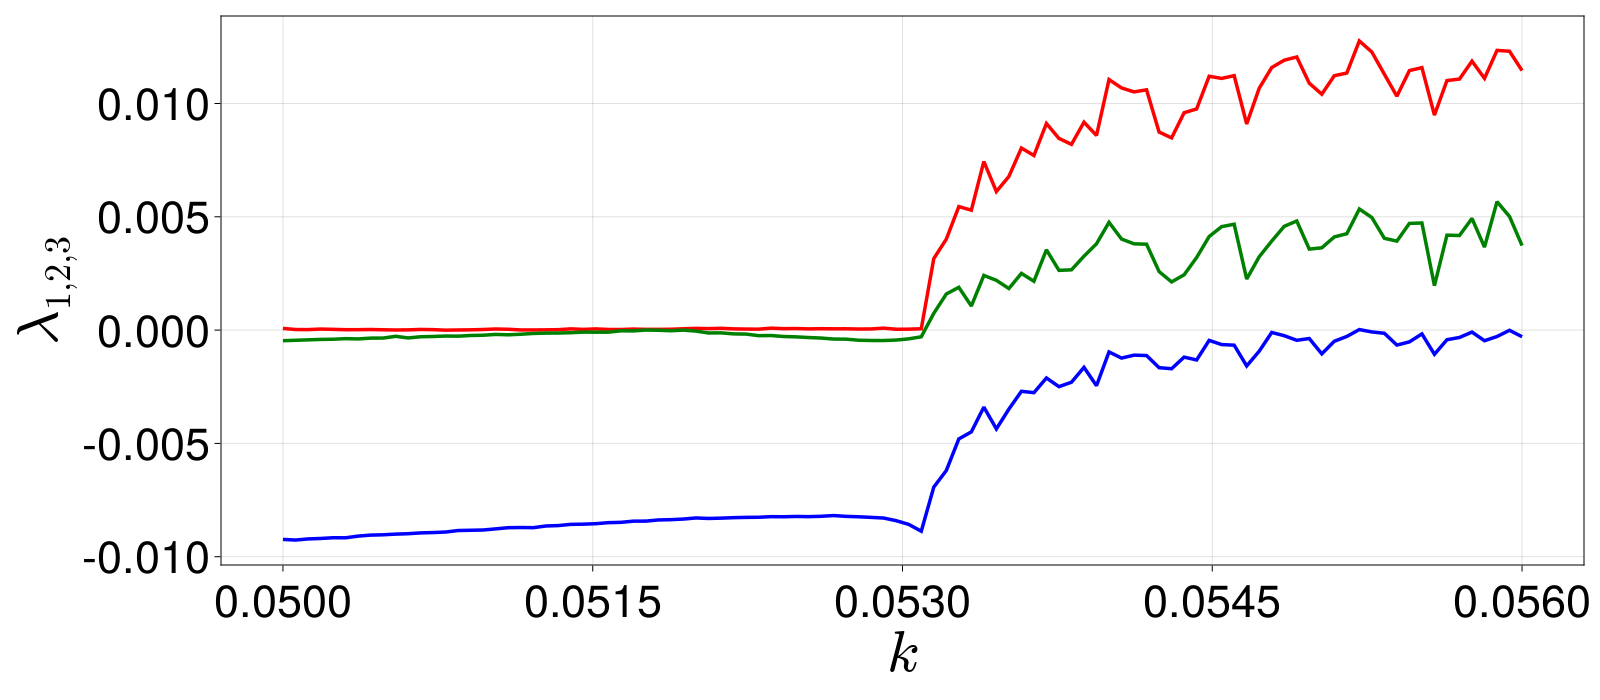

In [85]:
# L1
ticks = range(0.05, 0.056, length = 5)
f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45, xticks = ticks  )


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.5, color = "blue")
save("LE_orbit_zoom.eps", f)
f

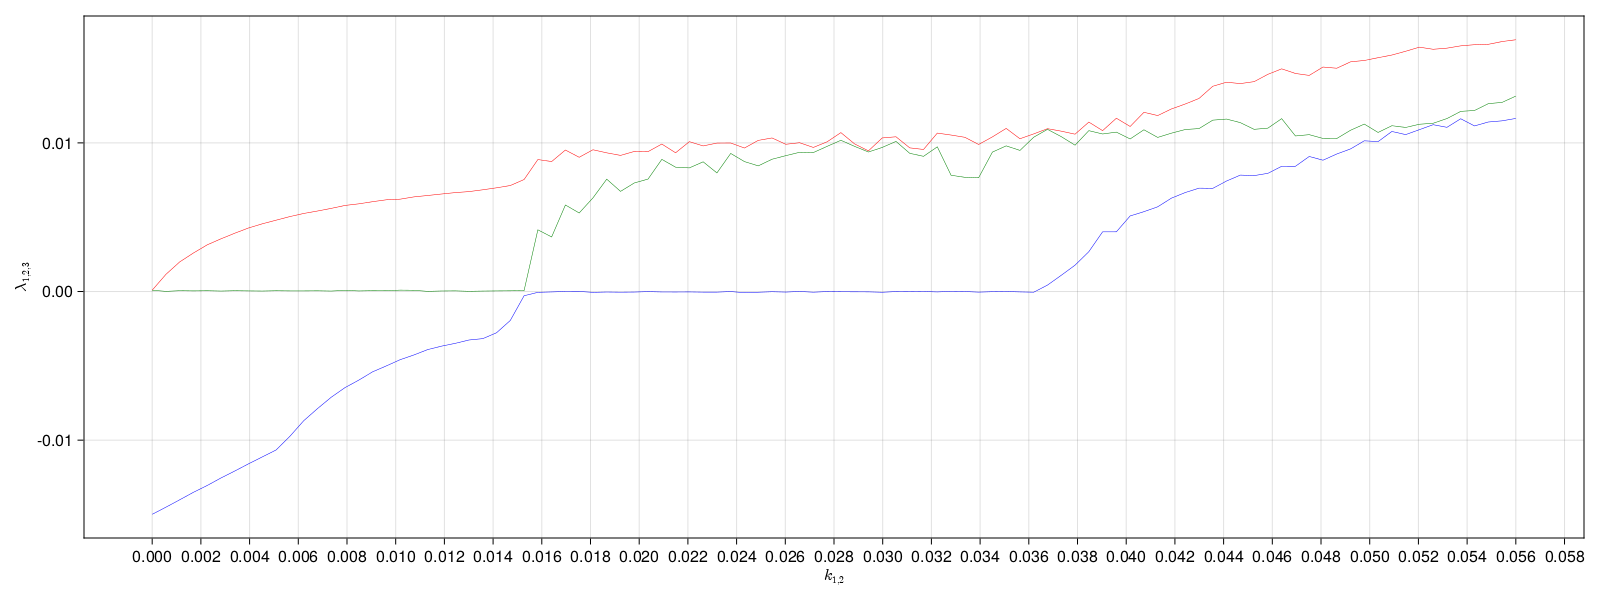

In [49]:
# L2
xticks = range(0.0, 0.56, step = 0.002)
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xticks = xticks)


lines!(ax, k_space, spectrum_array[1, :], linewidth = 0.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 0.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 0.5, color = "blue")
f